# **Project: Time Series - Forecasting Stock Prices**
# Marks: 30

Welcome to the project on Time Series. We will use the Amazon Stock Prices dataset for this project.
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Importing libraries

In [1]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models
#!pip install statsmodels --upgrade

In [2]:
#If the above command doesn't work, please run the below command in the anaconda prompt, otherwise ignore
#conda install statsmodels

In [3]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [4]:
#If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
#conda install -c anaconda xlrd

In [5]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Checking info 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   close   144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


**Observations:
- Data has only 2 coulumns which are date in datetime format and stock close amount for that day in float. 
- No missing or non-null values

In [7]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

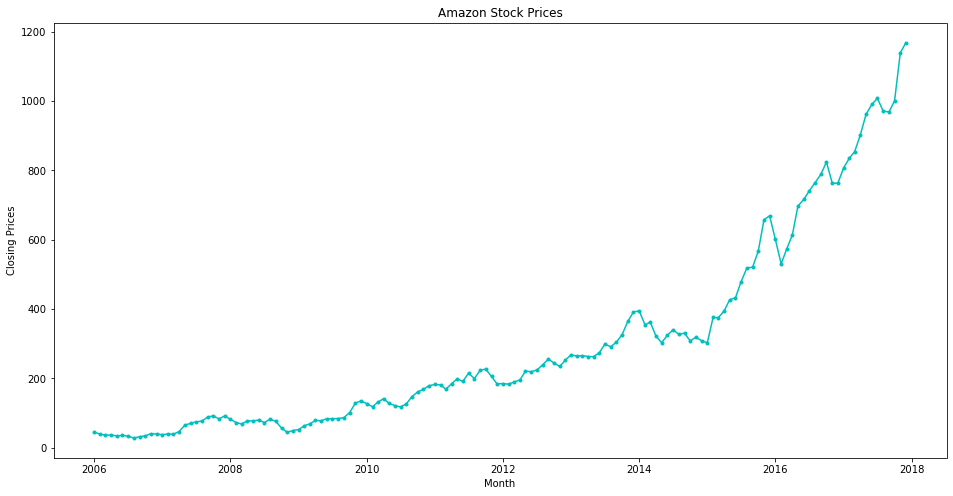

In [8]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

### Splitting the dataset

In [9]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Testing the stationarity of the series

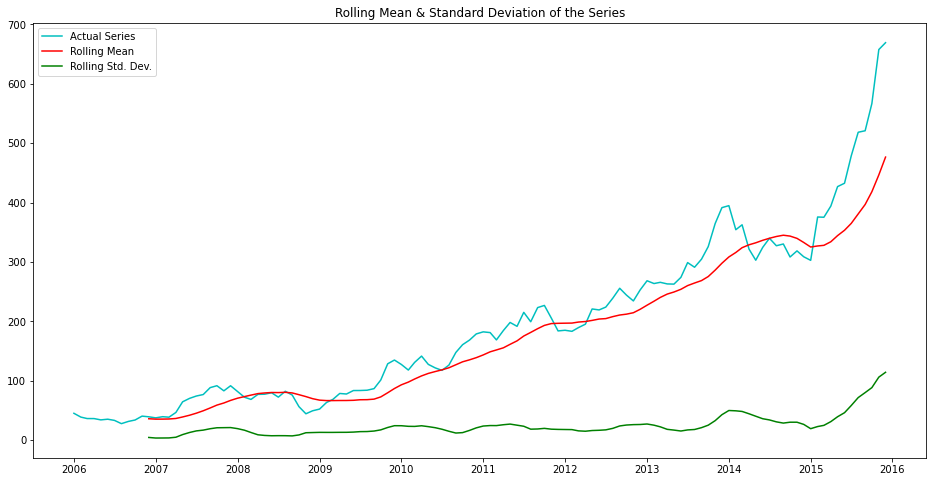

In [10]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [11]:
#Define a function to use adfuller test
def adfuller_2(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller_2(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

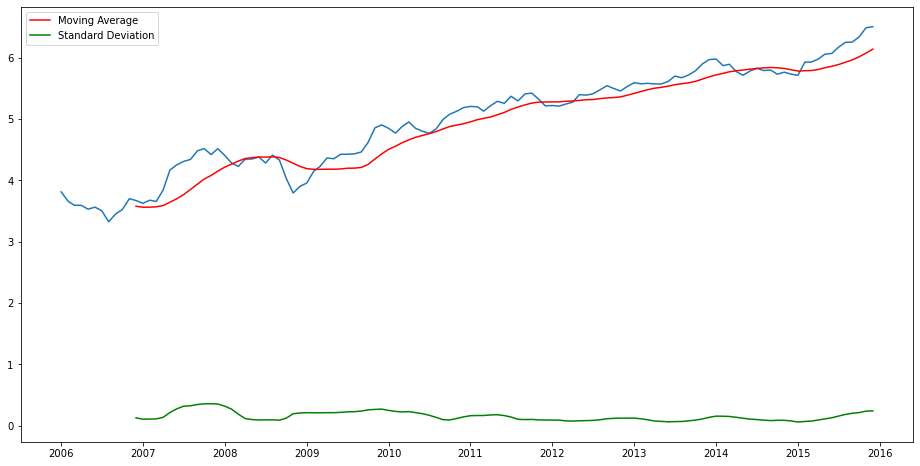

In [12]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

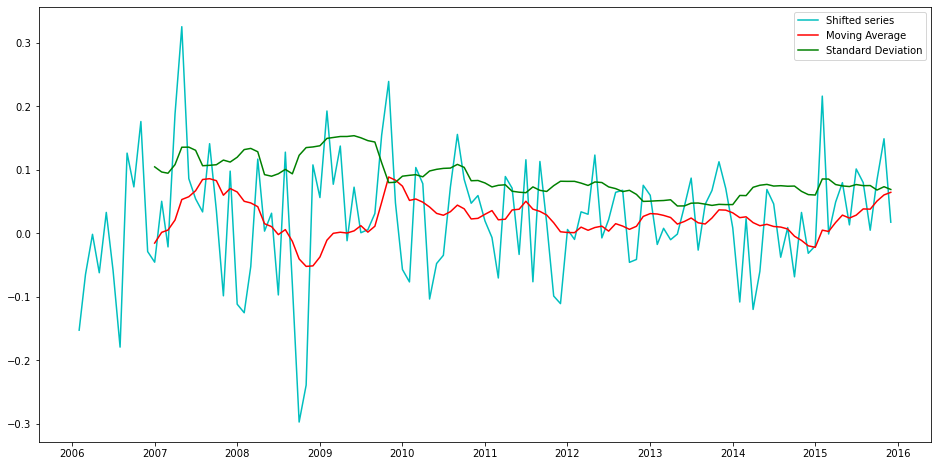

In [13]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c',label = 'Shifted series')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:
- We can see the MA and moving std dev be stationary and close to 0. 

Let us use the adfuller test to check the stationarity.

In [14]:
#____________________ # call the adfuller function for df_shift series
adfuller_2(df_shift)

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observations:**
- The p-value is now really close to 0, which is <0.05 ; as such we fail to reject the null hypothesis. 
- this series is now stationary

Let's decompose the time series to check its different components.

### Decomposing the time series components into Trend, Seasonality and Residual

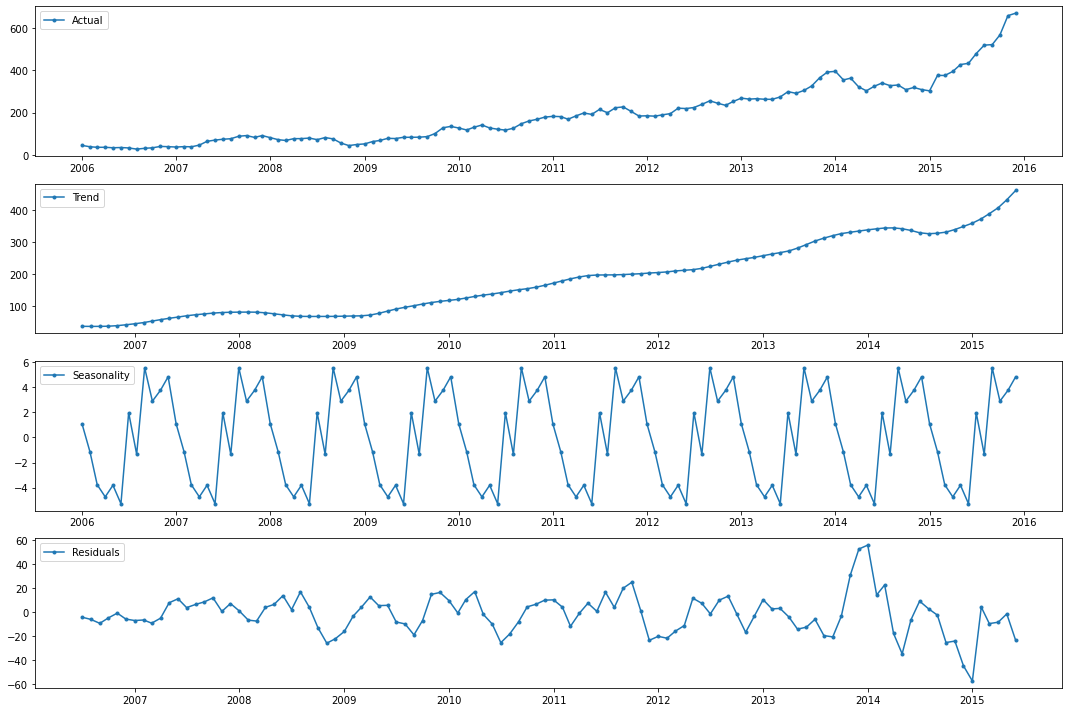

In [15]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

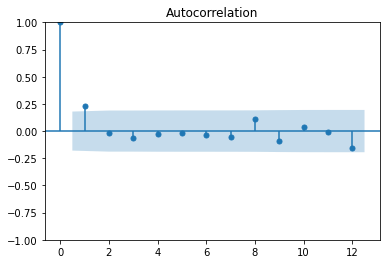

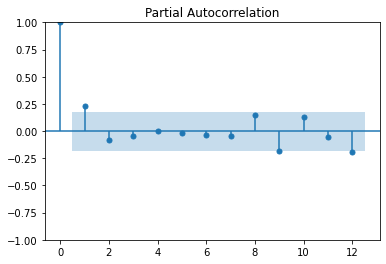

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Question 3: Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

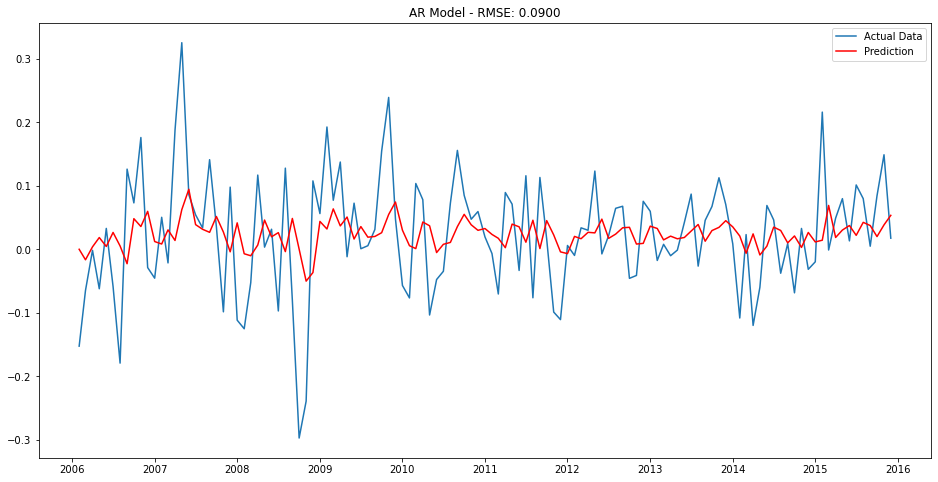

In [17]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift,lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
# plt.plot(df_train,label='Actual Data')

plt.plot(df_shift,label='Actual Data')
predict = results_AR.predict() #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot((predict), color='red',label='Prediction')
# plt.plot(np.exp(np.cumsum(predict)+3.6), color='red',label='Prediction')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.legend()
plt.show()

**Observations:_
- The RMSE looks good, however the variation doesnt seem to be correctly predicted by the AR model. THis may be due to the fact that AR doesnt model seasonality, we would need to use a SARIMA model for that purpose. 

**Let's check the AIC value** of the model

In [18]:
results_AR.aic

-229.33802078093757

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Question 4: Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

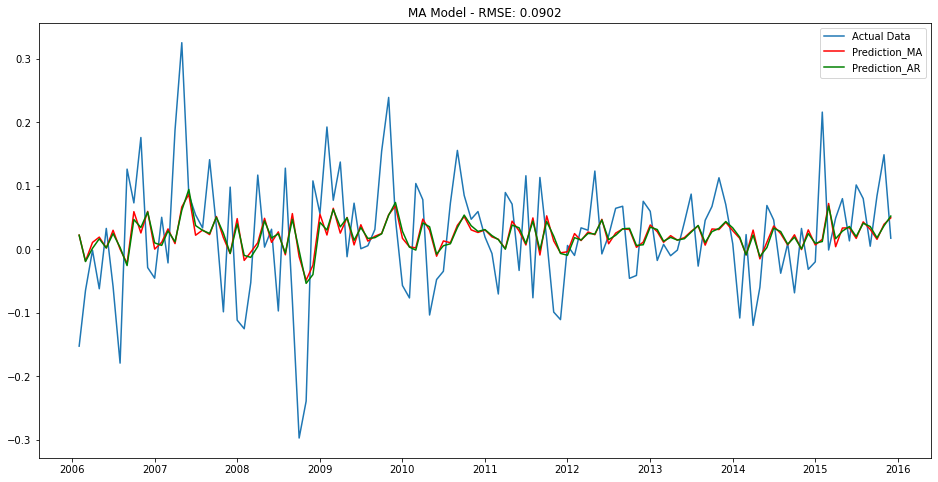

In [19]:
from statsmodels.tsa.arima.model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0, 0, 1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(df_shift,label='Actual Data')
plt.plot((results_MA.fittedvalues), color='red',label='Prediction_MA')

model_AR_2 = ARIMA(df_shift, order=(1, 0, 0)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_AR_2 = model_AR_2.fit() #fit the model
plt.plot((results_AR_2.fittedvalues), color='green',label='Prediction_AR')

plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.legend()
plt.show()

**Observations:__
- The RMSE for MA vs AR are pretty similar, We can see that the trend is followed correctly, however the variation is not being mapped as well. 

Let's check the AIC value of the model

In [20]:
results_MA.aic

-229.09493835479748

- **The AIC for AR vs MA is -229.34 vs -229.09.** These values are comparable, hence we cannot call one better than the other.  

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

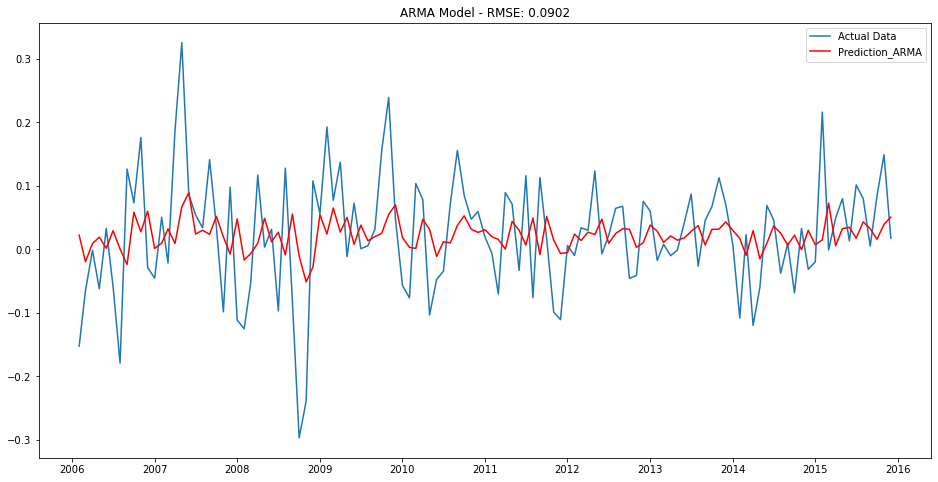

In [21]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
plt.plot(df_shift,label='Actual Data')
plt.plot((results_ARMA.fittedvalues), color='red',label='Prediction_ARMA')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.legend()
plt.show()

**Observations:**
- RMSE looks very similar to AR and MA models. This ARMA model is very similar to the AR and MA models. 

**Let's check the AIC value** of the model

In [22]:
results_ARMA.aic

-227.11129132564537

- **The AIC value of the ARMA model is more or less similar** to the AR and MA models 

**Let us try using the ARIMA Model.**

### ARIMA Model

We will be using an **ARIMA Model with p=1, d=1, & q=1**.

### **Question 6: Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

In [23]:
df_log.shape


(120, 1)

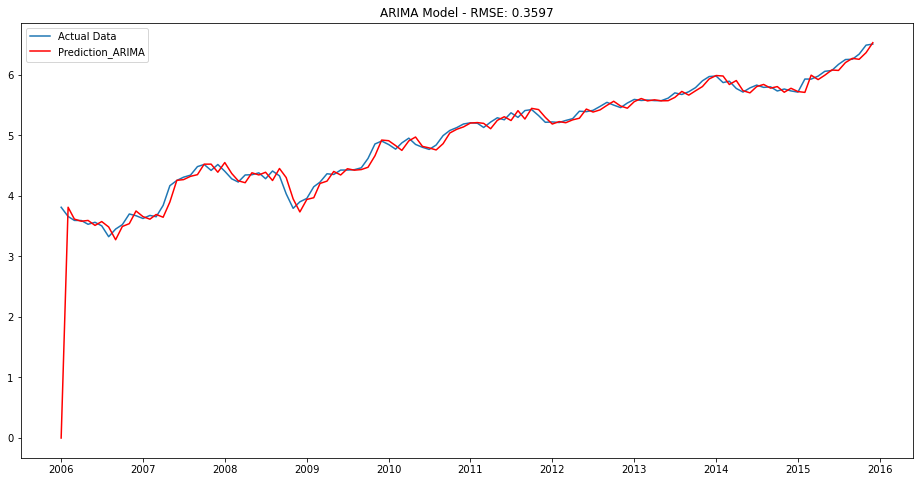

In [24]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1, 1, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_log,label='Actual Data')
plt.plot((results_ARIMA.fittedvalues), color='red',label='Prediction_ARIMA')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_log['close'], squared=False))
plt.legend()
plt.show()

In [25]:
#Actual ARIMA Error after removing 0 component and comparing with df_log
ARIMA_FIT_VAL=pd.Series(results_ARIMA.fittedvalues).iloc[1:]



actual_ARIMA_err=mean_squared_error(ARIMA_FIT_VAL,df_log['close'].iloc[1:], squared=False)
actual_ARIMA_err

0.0917517959267541

**Observations:_
- The RMSE only looks elevated due to the first prediction of the ARIMA fitted values being 0, the RMSE on this method is actually 0.0917
- Also, the .fittedvalues or .predict method for the ARIMA hands us the prediction against the log of the time series(df_log) and not the shifted series as in the previous example, this is because ARIMA can work with non stationary time series as well.

**Let's check the AIC value** of the model

In [26]:
results_ARIMA.aic

-224.93416324050222

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [27]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
# .iloc[1:]
# predictions.drop(index=pd.to_datetime('2006-01-01'))
# predictions.drop(index=df.index(datetime(2006, 1, 1)))
# predictions.drop(datetime(2006, 1, 1),axis=0)
# predictions.tail(predictions.shape[0] -1)

predictions

# predictions.index.dtype

# predictions.loc[predictions['date'] == '2006-01-01'].index

date
2006-01-01    0.000000
2006-02-01    3.811539
2006-03-01    3.615831
2006-04-01    3.580381
2006-05-01    3.593577
                ...   
2015-08-01    6.200570
2015-09-01    6.270539
2015-10-01    6.254640
2015-11-01    6.364665
2015-12-01    6.529215
Length: 120, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARIMA Model. (5 Marks)**

In [28]:
# WE DONT NEED TO RUN THIS PIECE OF CODE SINCE ARIMA hands us the prediction against the log of the time series(df_log) and not the shifted series. All we need to do is take the exp of the ARIMA fitted values

#First step - doing cumulative sum
# predictions_cumsum = _______________ # use .cumsum fuction on the predictions
# predictions_cumsum

In [29]:
# WE DONT NEED TO RUN THIS PIECE OF CODE SINCE ARIMA hands us the prediction against the log of the time series(df_log) and not the shifted series. All we need to do is take the exp of the ARIMA fitted values


#Second step - Adding the first value of the log series to the cumulative sum values
# predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
# # predictions_log
# predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
# predictions_log

In [30]:
#Third step - applying exponential transformation
predictions_ARIMA =  np.exp(predictions)
predictions_ARIMA


date
2006-01-01      1.000000
2006-02-01     45.220000
2006-03-01     37.182239
2006-04-01     35.887229
2006-05-01     36.363932
                 ...    
2015-08-01    493.030186
2015-09-01    528.762069
2015-10-01    520.421799
2015-11-01    580.950285
2015-12-01    684.860241
Length: 120, dtype: float64

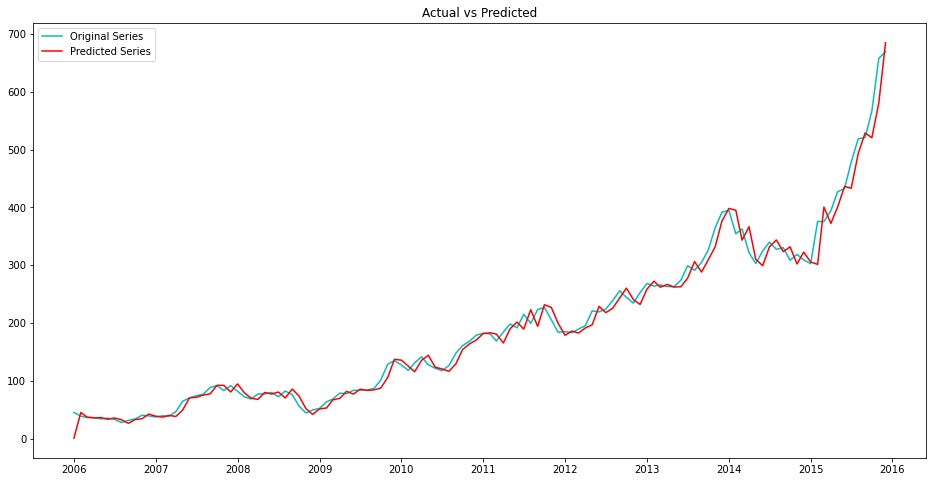

In [31]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data .
- Let us **forecast the closing prices for the next 24 months.**

### Forecasting the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [32]:
#Using auto_arima since the .predict() method for sm.ARIMA yeilded a straight line. 
from pmdarima.arima import auto_arima

auto_arima_model=auto_arima(df_log, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

a_a_preds=auto_arima_model.predict(n_periods=df_test.shape[0])
a_a_pred_series=pd.Series(a_a_preds)
auto_arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 117.547
Date:                Mon, 06 Dec 2021   AIC                           -229.095
Time:                        02:22:30   BIC                           -220.758
Sample:                             0   HQIC                          -225.709
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0223      0.010      2.131      0.033       0.002       0.043
ma.L1          0.2488      0.080      3.102      0.002       0.092       0.406
sigma2         0.0081      0.001      7.449      0.000       0.006       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.99   Prob(JB):                         0.71
Heteroskedasticity (H):               0.31   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
#Forecasting the values for next 24 months
# start_a = len(df_log)-10
# end_a = start_a+23
model_ARIMA = ARIMA(df_log, order=(1, 2, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model

# forecasted_ARIMA = results_ARIMA.predict()
# forecasted_ARIMA
# print(start_a,end_a)
forecasted_ARIMA = results_ARIMA.forecast(steps=24) #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA

# forecasted_ARIMA=results_ARIMA.predict(start=start_a,end=end_a)
# forecasted_ARIMA
# predictions_b=[]
# for i in range(24):
#     model_ARIMA = ARIMA(df_log, order=(1, 1, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
#     results_ARIMA = model_ARIMA.fit() #fit the model
#     forecasted_ARIMA = results_ARIMA.forecast()
#     df_log.append(forecasted_ARIMA,ignore_index=True)
#     print(df_log.shape)
#     predictions_b.append(forecasted_ARIMA)
    # predictions_f.append(yhat_f)

# predictions_b
# results_ARIMA.append(forecasted_ARIMA)
# results_ARIMA

2016-01-01    6.527147
2016-02-01    6.549002
2016-03-01    6.571076
2016-04-01    6.593205
2016-05-01    6.615346
2016-06-01    6.637491
2016-07-01    6.659637
2016-08-01    6.681784
2016-09-01    6.703930
2016-10-01    6.726076
2016-11-01    6.748222
2016-12-01    6.770368
2017-01-01    6.792514
2017-02-01    6.814661
2017-03-01    6.836807
2017-04-01    6.858953
2017-05-01    6.881099
2017-06-01    6.903245
2017-07-01    6.925392
2017-08-01    6.947538
2017-09-01    6.969684
2017-10-01    6.991830
2017-11-01    7.013976
2017-12-01    7.036123
Freq: MS, Name: predicted_mean, dtype: float64

In [51]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA.tolist()
series1 = pd.Series(list1)
# series1

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [52]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-01-1' , freq='1M')- pd.offsets.MonthBegin(1)

df1 = pd.DataFrame()
df1['forecasted'] = forecasted_ARIMA
df1.index = index


In [57]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = np.exp(forecasted_ARIMA) #use exponential function on forecasted data
forecasted_ARIMA


2016-01-01     683.445495
2016-02-01     698.546878
2016-03-01     714.138070
2016-04-01     730.116863
2016-05-01     746.463231
2016-06-01     763.178124
2016-07-01     780.267945
2016-08-01     797.740622
2016-09-01     815.604610
2016-10-01     833.868640
2016-11-01     852.541664
2016-12-01     871.632838
2017-01-01     891.151526
2017-02-01     911.107301
2017-03-01     931.509950
2017-04-01     952.369481
2017-05-01     973.696124
2017-06-01     995.500340
2017-07-01    1017.792823
2017-08-01    1040.584507
2017-09-01    1063.886571
2017-10-01    1087.710444
2017-11-01    1112.067810
2017-12-01    1136.970617
Freq: MS, Name: predicted_mean, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

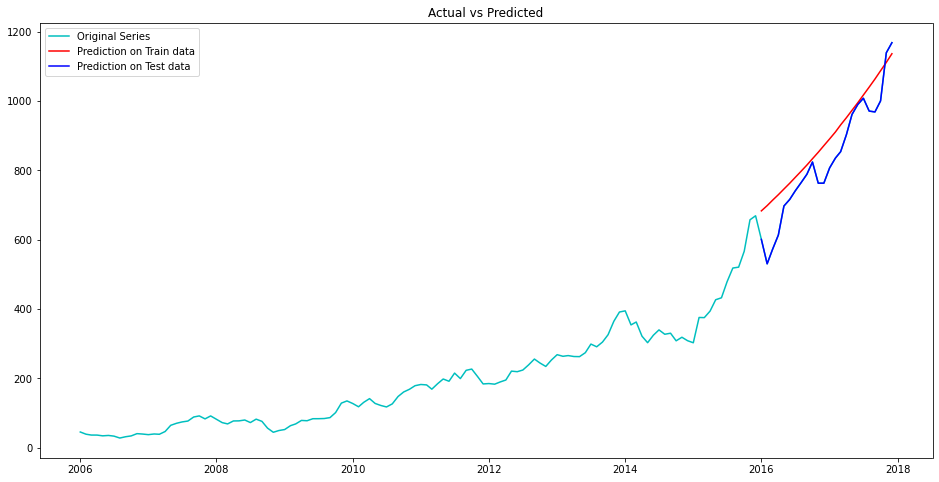

In [58]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(forecasted_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(df_test, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [38]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(predictions_ARIMA,df_train, squared=False) #calculate RMSE using the predictions_ARIMA and df_train 
error


17.99017289578111

In [39]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_ARIMA,df_test, squared=False) #calculate RMSE using the forecasted_ARIMA and df_test
error


73.22074364266413

### Conclusion
- We have concluded from the ACF and PACF that the order of the ARIMA should be (1,1,1). When running the auto_arima() we are suggested to use (0,1,1). 
- We have an RMSE of 18 on the train data as compared to an RMSE of 73.2 on the forecast.
- We have a larger RMSE on the test dataset, this is probably due to the fluctuations that we see in the test data which the trained model cannot account for, probably on account of external factors. 
- OVerall, the ARIMA does show a good overall trend, despite not being able to account for the fluctuations. 

**Write your conclusion here**

In [40]:
import os
os.system('jupyter nbconvert --to html Vishwesh_Chaubal_Time_Series.ipynb')

0